In [197]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import time
import csv
import h5py
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input, MaxPooling2D, Subtract
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.layers.merge import _Merge
from keras.engine.topology import Layer
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
from keras.initializers import RandomNormal
np.random.seed(1234)
from keras.utils import plot_model
import keras.backend.tensorflow_backend as Kback
from IPython.display import clear_output
import keras as K
import tensorflow as tf
import scipy.io as sio
from scipy import stats
import scipy as scp
import keras
from keras.backend.tensorflow_backend import set_session
import os
import random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=1
set_session(tf.Session(config=config))

In [2]:
#Load data
f = h5py.File('cropped.mat')

In [3]:
#input_parameters
hrz = 40
vrt = 40
x_train = {}
x_train_small_pre = np.ndarray((14114,hrz,vrt,3),int)
x_train_small = np.ndarray((14114,hrz,vrt,3),int)
x_train = f['bigdata'][()]
print(x_train.shape)
x_train_s = np.swapaxes(x_train,0,3)
x_train_s = np.swapaxes(x_train_s,1,2)
print(x_train_s.shape)

(3, 210, 165, 14114)
(14114, 165, 210, 3)


In [4]:
for j in range(0,x_train_s.shape[0]):
    pic = scp.misc.imresize(x_train_s[j,:,:,:],(hrz,vrt,3))
    x_train_small_pre[j,:,:,:] = pic 
print(x_train_s[14113,1,1,1])
print(pic[1,1,1])

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


0.5058823529411764
136


In [5]:
print(x_train_small_pre.shape)
x_train_small_pre = np.random.permutation(x_train_small_pre)
print(x_train_small_pre.shape)

(14114, 40, 40, 3)
(14114, 40, 40, 3)


(14114, 40, 40, 3)
(40, 40, 3)
187


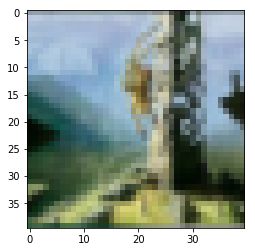

In [6]:
print(x_train_small_pre.shape)
probe = random.randint(0,14114)
testpic = x_train_small_pre[probe,:,:,:]
print(testpic.shape)
plt.imshow(testpic.astype(np.uint8)) 
print(max(testpic[:,0,0]))

0.3941176470588235
-0.49607843137254903
228.0
1.0


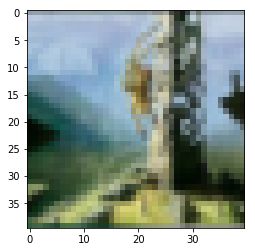

In [7]:
x_train_small = (x_train_small_pre-127.5)/255
#x_train_small = x_train_small_pre/255

testpic_sml = x_train_small[probe,:,:,:]
print(np.amax(testpic_sml[:,:,2]))
print(np.amin(testpic_sml[:,:,2]))

testpic = ((x_train_small[probe,:,:,:]*255)+127.5)
#testpic = x_train_small[probe,:,:,:]*255
print(np.amax(testpic[:,:,2]))
print(np.amin(testpic[:,:,2]))
plt.imshow(testpic.astype(np.uint8)) 

In [225]:
def multiple_loss(y_true, y_pred):
    return Kback.mean(y_true * y_pred)

def mean_loss(y_true, y_pred):
    return Kback.mean(y_pred)

class Substract(_Merge):
    def _merge_function(self, inputs):
        output = inputs[0]
        for i in range(1, len(inputs)):
            output = output-inputs[i]
        return output
    
class GradNorm(Layer):
    def __init__(self, **kwargs):
        super(GradNorm, self).__init__(**kwargs)

    def build(self, input_shapes):
        super(GradNorm, self).build(input_shapes)

    def call(self, inputs):
        target, wrt = inputs
        grads = Kback.gradients(target, wrt)
        assert len(grads) == 1
        grad = grads[0]
        return Kback.sqrt(Kback.sum(Kback.batch_flatten(Kback.square(grad)), axis=1, keepdims=True))

    def compute_output_shape(self, input_shapes):
        return (input_shapes[1][0], 1)

In [258]:
class DCGAN():
    def __init__(self,param):
        self.img_rows =hrz
        self.img_cols = vrt
        self.channels = 3
        self.img_shape = (self.img_rows,self.img_cols,self.channels)
        self.latent_dim = 500
        self.lmbd = 10;
        #self.weight_init = RandomNormal(mean=0., stddev=0.02)
        self.weight_init = 'glorot_uniform'
        learning_rate_gen =  0.0005 
        learning_rate_disc = 0.00005 

        optimizer_gen = RMSprop(lr = learning_rate_gen) 
        optimizer_disc = RMSprop(lr = learning_rate_disc)  
        #optimizer_gen = Adam(lr = learning_rate_gen,beta_1 = 0.5, beta_2 = 0.999) 
        #optimizer_disc = Adam(lr = learning_rate_disc,beta_1 = 0.5, beta_2 = 0.999) 
        
        #build opponents
        self.generator = self.build_generator(int(param[1]))
        self.discriminator = self.build_discriminator(int(param[0]))
        
        #build and compile COMBINED model
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        self.gendis = Sequential([self.generator,self.discriminator], name = 'gendis')
        self.gendis.compile(loss = multiple_loss, optimizer = optimizer_gen)
    
        #build and compile DISCRIMINATOR model       
        shape = self.discriminator.get_input_shape_at(0)[1:]
        gen_input, real_input, interpolation = Input(shape), Input(shape), Input(shape)
        sub = Subtract()([self.discriminator(gen_input), self.discriminator(real_input)])
        norm = GradNorm()([self.discriminator(interpolation), interpolation])
        self.dis2batch = Model([gen_input, real_input, interpolation], [sub, norm]) 

        self.discriminator.trainable = True
        self.dis2batch.compile(optimizer = optimizer_disc,loss = [mean_loss, 'mse'],  loss_weights=[1.0,self.lmbd])
            
        
    #Build Discriminator
    def build_discriminator(self,depth):
        dropout = 0 #0.5
        input_shape = (hrz,vrt,3)

        discriminator_model = Sequential(name='discriminator')

        discriminator_model.add(Conv2D(depth*2,kernel_size =  3, strides=1,input_shape = input_shape, kernel_initializer = self.weight_init, padding ='same'))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))

        discriminator_model.add(Conv2D(depth*4,kernel_size = 4,strides=2, padding ='same', kernel_initializer = self.weight_init))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))
        
#         discriminator_model.add(Conv2D(depth*2,kernel_size = 4,strides=1, padding ='same'))
#         discriminator_model.add(BatchNormalization(momentum=0.8))
#         discriminator_model.add(LeakyReLU(alpha = 0.2))
#         discriminator_model.add(Dropout(dropout))

        discriminator_model.add(Conv2D(depth*4,kernel_size = 4,strides=2, padding ='same', kernel_initializer = self.weight_init))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))
        
        discriminator_model.add(Conv2D(depth*8,kernel_size = 4,strides=2, padding ='same', kernel_initializer = self.weight_init))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))
        
        discriminator_model.add(Flatten())
        discriminator_model.add(Dense(1))
        #discriminator_model.add(Activation('sigmoid'))
        return discriminator_model
    
    #Build generator
    def build_generator(self,depth):
        #depth = 32
        dropout  = 0 #0.5
        dim = 5
        
        generator_model = Sequential(name='generator')

        generator_model.add(Dense(depth*8*dim*dim,input_dim=self.latent_dim, kernel_initializer = self.weight_init))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))
        generator_model.add(Reshape((dim,dim,depth*8)))
        
        generator_model.add(Conv2DTranspose(depth*8,kernel_size = 5, strides = 2, padding ='same', kernel_initializer = self.weight_init))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))

#         generator_model.add(Conv2D(depth*2,kernel_size = 5, strides = 1, padding ='same'))
#         generator_model.add(Dropout(dropout))
#         generator_model.add(BatchNormalization(momentum=0.8))
#         generator_model.add(LeakyReLU(alpha = 0.2))
        
        generator_model.add(Conv2DTranspose(depth*8,kernel_size = 5, strides = 2, padding ='same', kernel_initializer = self.weight_init))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))
        
#         generator_model.add(Conv2D(depth*2,kernel_size = 5, strides = 1, padding ='same'))
#         generator_model.add(Dropout(dropout))
#         generator_model.add(BatchNormalization(momentum=0.8))
#         generator_model.add(LeakyReLU(alpha = 0.2))
        
        generator_model.add(Conv2DTranspose(depth*4,kernel_size = 5, strides = 2, padding ='same', kernel_initializer = self.weight_init))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))

        generator_model.add(Conv2D(self.channels,kernel_size = 5, strides = 1, padding ='same', kernel_initializer = self.weight_init))
        generator_model.add(Activation("tanh"))

        noise = Input(shape = (self.latent_dim,))
        img = generator_model(noise)
        return generator_model

In [259]:
#Training
epochs =5000
batch_size = 64
d_losses = np.ones([epochs,2])
g_losses = np.ones([epochs,2])

In [260]:
#tRAINING
loopits = 1;
param = np.ones([2,loopits])
fake_samples =  np.ones([loopits,4,hrz,vrt,3])
trajec_fake_samples =  np.ones([loopits,epochs,hrz,vrt,3])
capacity = 16;
handicap = 4;
clip_value = 0.01
param[0][:] = [capacity*1] #discriminator
param[1][:] = [capacity*1] #generator

d_loss_l= np.ones([loopits,epochs,2])
d_diff_l= np.ones([loopits,epochs,2])
d_norm_l= np.ones([loopits,epochs,2])
g_losses = np.ones([loopits,epochs,2])
for looper in range(loopits):
    DCGAN_model = DCGAN(param[:,looper])
    DCGAN_model.generator.summary()
    DCGAN_model.discriminator.summary()
    #DCGAN_model.dis2batch.summary()
    #DCGAN_model.gendis.summary()
  
    for epoch in range(epochs):
        clear_output(wait=True)
        print(looper)
        print(epoch)
        #sample batchfull of training pictures
        idx = np.random.randint(0,x_train.shape[0],int(batch_size))
        imgs = x_train_small[idx]
        
        #sample noice and generate fake images
        #Z = np.random.normal(0,1.0, (int(batch_size),DCGAN_model.latent_dim))
        Z = np.random.uniform(-1,1.0, (batch_size,DCGAN_model.latent_dim))
        gen_imgs = DCGAN_model.generator.predict(Z)

        #train generator
        if epoch%5==1: 
            y_true = np.ones([batch_size,1])*-1
            if handicap < epoch:
                g_loss = DCGAN_model.gendis.train_on_batch(Z,y_true)
                g_losses[looper,epoch] = g_loss
        
        #train discriminator
        epsilon = np.random.uniform(0,1,size=(batch_size,1,1,1))
        interpolation = epsilon*imgs + (1-epsilon)*gen_imgs
        d_loss, d_diff, d_norm = DCGAN_model.dis2batch.train_on_batch([gen_imgs,imgs,interpolation],[np.ones((batch_size,1))]*2)    
        d_loss_l[looper,epoch] = d_loss
        d_diff_l[looper,epoch] = d_diff
        d_norm_l[looper,epoch] = d_norm
    
    for sample in range(4):
        
        #Z = np.random.normal(0,1.0, size=[batch_size,DCGAN_model.latent_dim])
        Z = np.random.uniform(-1,1.0, (batch_size,DCGAN_model.latent_dim))
        images_good_fake = DCGAN_model.generator.predict(Z)
        fake_sample = (np.squeeze(images_good_fake[1,:,:,:]))  
        fake_samples[looper,sample,:,:,:] = fake_sample


0
4999


-0.5189663767814636
-0.5192395448684692
-0.6263306736946106
0.9394620060920715
0.9655881524085999
0.9465636014938354


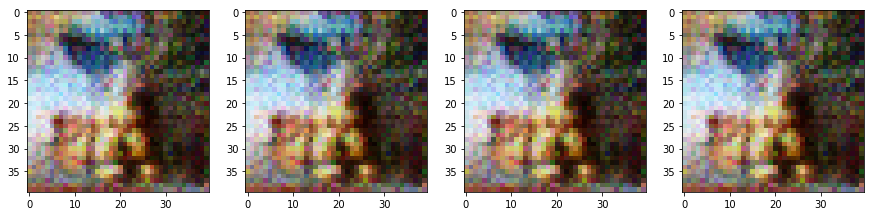

In [265]:
for sample in range(4):

    Z = np.random.uniform(-1,1.0, (batch_size,DCGAN_model.latent_dim))
    images_good_fake = DCGAN_model.generator.predict(Z)
    fake_sample = (np.squeeze(images_good_fake[1,:,:,:]))  
    fake_samples[looper,sample,:,:,:] = fake_sample

width = 15
height = 15
plt.figure(figsize=(width,height))
plotcounter = 1;

print(np.amin(fake_samples[0,:,:,0]))
print(np.amin(fake_samples[0,:,:,1]))
print(np.amin(fake_samples[0,:,:,2]))
print(np.amax(fake_samples[0,:,:,0]))
print(np.amax(fake_samples[0,:,:,1]))
print(np.amax(fake_samples[0,:,:,2]))

fake_samples_scaled = (fake_samples+1)/2

for looper in range(loopits):
 
    plt.subplot(loopits,4,plotcounter)
    plt.imshow(fake_samples_scaled[looper,0,:,:])
    plt.subplot(loopits,4,plotcounter+1)
    plt.imshow(fake_samples_scaled[looper,1,:,:])
    plt.subplot(loopits,4,plotcounter+2)
    plt.imshow(fake_samples_scaled[looper,2,:,:])
    plt.subplot(loopits,4,plotcounter+3)
    plt.imshow(fake_samples_scaled[looper,3,:,:])
    plotcounter = plotcounter+4

(-10, 10)

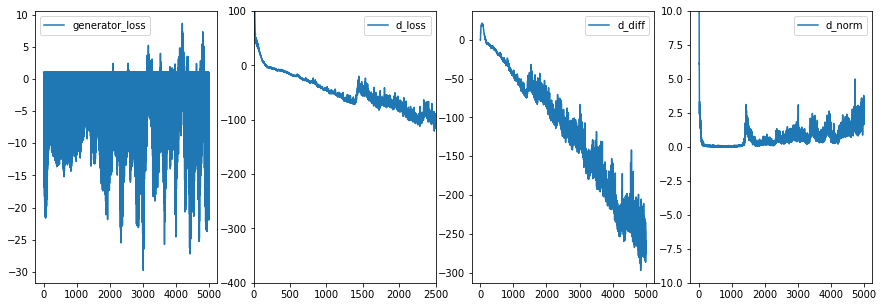

In [266]:
width = 15
height = 5
plt.figure(figsize=(width,height))
plt.subplot(1,4,1)
g_losses_plot = np.swapaxes(g_losses,0,1)
plt.plot(g_losses_plot[:,:,0],label='generator_loss')
#plt.ylim((-0.002,0.002))
plt.legend()

plt.subplot(1,4,2)
d_loss_plot = np.swapaxes(d_loss_l,0,1)
plt.plot(d_loss_plot[:,:,0] ,label='d_loss')
plt.xlim((0,epoch/2))
plt.legend()
plt.ylim((-400,100))

plt.subplot(1,4,3)
d_diff_plot = np.swapaxes(d_diff_l,0,1)
plt.plot(d_diff_plot[:,:,0] ,label='d_diff')
plt.legend()

plt.subplot(1,4,4)
d_norm_plot = np.swapaxes(d_norm_l,0,1)
plt.plot(d_norm_plot[:,:,0] ,label='d_norm')
plt.legend()
plt.ylim((-10,10))